In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.drop('customerID',axis=1,inplace=True)
df = df[df['TotalCharges']!=' ']

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [5]:
df.replace(['No phone service','No internet service'],'No',inplace=True)

In [6]:
x = df.iloc[::,0:-1]
y = df.iloc[::,-1]
y.replace({'No':0,'Yes':1},inplace=True)
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [7]:
categorical_features = list(df.select_dtypes(include=[object]).columns)
categorical_features.append('SeniorCitizen')
numerical_features = list(df.select_dtypes(include=[int,float]).columns)
numerical_features.remove('SeniorCitizen')
numerical_features.remove('Churn')

In [8]:
numerical_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [9]:
num_pipeline = Pipeline(
    steps=[
        ('impute',SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ]
)
cat_pipeline = Pipeline(
    steps = [
        ('impute',SimpleImputer(strategy='most_frequent')),
        ('OneHotEncoder',OneHotEncoder()),
        ('scaler',StandardScaler(with_mean=False))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num_pipeine',num_pipeline,numerical_features),
        ('cat_pipeline',cat_pipeline,categorical_features)
    ]
)

In [10]:
x = preprocessor.fit_transform(x)
x

array([[-1.28024804, -1.16169394, -0.99419409, ...,  0.        ,
         2.71136611,  0.        ],
       [ 0.06430269, -0.26087792, -0.17373982, ...,  2.38317953,
         2.71136611,  0.        ],
       [-1.23950408, -0.36392329, -0.95964911, ...,  2.38317953,
         2.71136611,  0.        ],
       ...,
       [-0.87280842, -1.17000405, -0.85451414, ...,  0.        ,
         2.71136611,  0.        ],
       [-1.15801615,  0.31916782, -0.87209546, ...,  2.38317953,
         0.        ,  2.71136611],
       [ 1.36810945,  1.35793167,  2.01234407, ...,  0.        ,
         2.71136611,  0.        ]])

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state=42)

In [12]:
models = {
    'LogisticRegression':LogisticRegression(),
    'SVC':SVC(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'XGBClassifier':XGBClassifier(),
    'CatBoostClassifier':CatBoostClassifier(verbose=False),
    'DecisionTreeClassifier' : DecisionTreeClassifier(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'GaussianNB':GaussianNB()
}

In [13]:
param = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10],
        #'pca__n_components': [None, 2, 5, 10, 15]  
    },
    'SVC':{
        'kernel': ['linear', 'rbf'],
        'C': [1, 10, 100],
        'gamma': [0.01, 0.001, 0.0001]
    },
    'AdaBoostClassifier':{
        'n_estimators': [100,200,300],
        'learning_rate': [0.01, 0.05, 0.1],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'XGBClassifier':{
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'booster':['gbtree','gblinear']
    },
    'CatBoostClassifier':{
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 4, 5, 6]
    },
    'DecisionTreeClassifier':{
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        #'pca__n_components': [None, 2, 5, 10, 15]
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        #'pca__n_components': [None, 2, 5, 10, 15]
    },
    'GaussianNB': {
        #'pca__n_components': [None, 2, 5, 10, 15]
    }
}


In [14]:
models_dict = {}
for model_name,model in models.items():
    #pipe = Pipeline(steps=[('pca',PCA()),('model',model)])
    gs = GridSearchCV(estimator=model, param_grid=param[model_name], cv=5, verbose=0)
    gs.fit(x_train,y_train)
    model.set_params(**gs.best_params_)
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test,pred)
    models_dict[model_name] = accuracy

/home/darnesh/projects/Customer_churn_prediction/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/darnesh/projects/Customer_churn_prediction/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

[17:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[17:32:55] WARNING: ../src/learner.cc:767: 

In [15]:
models_df = pd.DataFrame(list(models_dict.items()),columns=['Model','Accuracy']).sort_values(by='Accuracy',ascending=False)
models_df

,Model,Accuracy
4,CatBoostClassifier,0.800474
3,XGBClassifier,0.797630
0,LogisticRegression,0.794787
2,AdaBoostClassifier,0.794313
1,SVC,0.792891
7,RandomForestClassifier,0.789573
5,DecisionTreeClassifier,0.781991
6,KNeighborsClassifier,0.761137
8,GaussianNB,0.750711


In [16]:
best_model = models['CatBoostClassifier']

In [19]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [23]:
cm = confusion_matrix(y_test,predicted)
cm

array([[1409,  140],
       [ 281,  280]])

In [21]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.67      0.50      0.57       561

    accuracy                           0.80      2110
   macro avg       0.75      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110



Text(0.5, 1.0, 'Confusion Matrix')

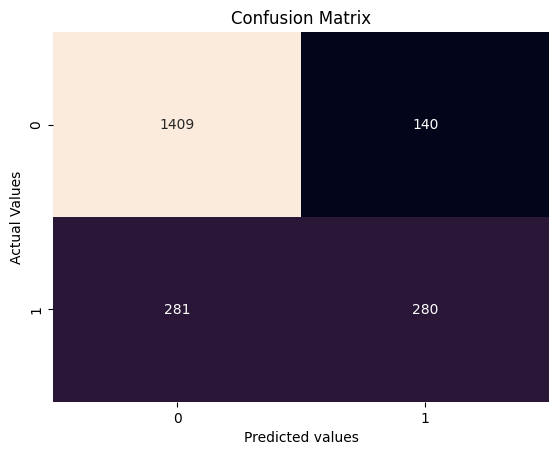

In [30]:
sns.heatmap(cm,annot=True,fmt='d',cbar=False,)
plt.ylabel('Actual Values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')